In [30]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

## Baseline Score

In [2]:
data = pd.read_csv("../data/metrics/insurance_ML3.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges,price_range
0,19,female,27.900,0,True,southwest,16884.92400,expensive
1,18,male,33.770,1,False,southeast,1725.55230,cheap
2,28,male,33.000,3,False,southeast,4449.46200,cheap
3,33,male,22.705,0,False,northwest,21984.47061,expensive
4,32,male,28.880,0,False,northwest,3866.85520,cheap


### Regression baseline

In [3]:
X = data[['age', 'bmi', 'children', 'smoker']]
y = data['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

baseline_model = DummyRegressor(strategy="mean")
baseline_model.fit(X_train, y_train)
baseline_model.score(X_test, y_test)

-0.001233635021205659

In [4]:
model = LinearRegression().fit(X_train, y_train)
model.score(X_test, y_test)

0.773425820295562

## Comparing metrics

In [7]:
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

In [9]:
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
rsquared = r2_score(y_test, y_pred)
max_error = max_error(y_test, y_test)

print('MSE =', round(mse, 2))
print('RMSE =', round(rmse, 2))
print('MAE =', round(mae, 2))
print('R2 =', round(rsquared, 2))
print('Max Error =', round(max_error, 2))

MSE = 31208571.22
RMSE = 5586.46
MAE = 4017.24
R2 = 0.77
Max Error = 0.0


## Metrics during Cross-validantion

In [11]:
# 5-Fold Cross validate model
model = LinearRegression()
# Quanto maior o score, melhor o modelo
cv_results = cross_validate(model, X, y, cv=5,
                            scoring=['max_error', 'r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'])
pd.DataFrame(cv_results) # Cross-validation output

,fit_time,score_time,test_max_error,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error
0,0.002614,0.002599,-24053.301788,0.760959,-4210.447467,-3.714635e+07
1,0.002801,0.002720,-23060.600919,0.708823,-4219.303638,-3.781926e+07
2,0.002279,0.002588,-26395.712047,0.776167,-4026.911043,-3.285122e+07
3,0.001972,0.002697,-23282.860901,0.731409,-4297.280431,-3.987217e+07
4,0.002096,0.002820,-29700.376643,0.756647,-4218.673537,-3.696269e+07


In [12]:
cv_results['test_r2'].mean()

np.float64(0.7468009563921238)

## Confusion Matrix

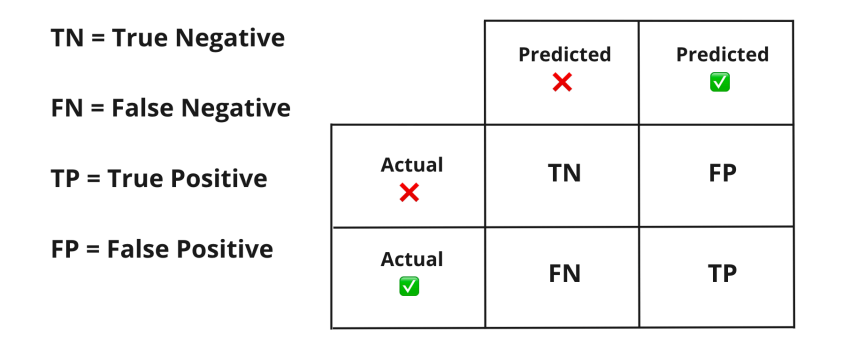

In [15]:
y_test = [0, 1, 0, 0, 1, 0, 1, 1, 0, 1] # actual truths
preds = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1] # predictions

results_df = pd.DataFrame({"actual": y_test, "predicted": preds})
confusion_matrix = pd.crosstab(index=results_df["actual"], columns=results_df["predicted"])
confusion_matrix.head()

predicted,0,1
actual,,
0,3,2
1,1,4


## Comparing metrics (classification)

In [19]:
y_true = [0, 1, 0, 0, 1, 0, 1, 1, 0, 1]
y_pred = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]

print('Accuracy =', round(accuracy_score(y_true, y_pred), 2)) # Accuracy
print('Precision =', round(precision_score(y_true, y_pred), 2)) # Precision
print('Recall =', round(recall_score(y_true, y_pred), 2)) # Recall
print('F1 score =', round(f1_score(y_true, y_pred), 2)) # F1 score

Accuracy = 0.7
Precision = 0.67
Recall = 0.8
F1 score = 0.73


## precision_recall_curve

Problema: Estamos trabalhando em uma seguradora tentando prever se uma apólice será cara ou não. Nosso chefe
nos informou que nosso modelo anterior oferecia apólices mais baratas do que o esperado aos clientes, causando
prejuízos à empresa.
Eles querem que pelo menos 80% dos clientes com apólices caras sejam identificados.

In [21]:
data.head()

,age,sex,bmi,children,smoker,region,charges,price_range
0,19,female,27.900,0,True,southwest,16884.92400,expensive
1,18,male,33.770,1,False,southeast,1725.55230,cheap
2,28,male,33.000,3,False,southeast,4449.46200,cheap
3,33,male,22.705,0,False,northwest,21984.47061,expensive
4,32,male,28.880,0,False,northwest,3866.85520,cheap


In [22]:
# we should optimize for recall -> a classe de foco é 1 para expensive_policy e o modelo deve forcar em positives
le = LabelEncoder()
le.fit(data['price_range'])

print(le.classes_) # to check the order of classes that will be encoded

data['price_range_encoded'] = le.transform(data['price_range'])
data[['price_range', 'price_range_encoded']].head()

['cheap' 'expensive']


,price_range,price_range_encoded
0,expensive,1
1,cheap,0
2,cheap,0
3,expensive,1
4,cheap,0


In [24]:
model = LogisticRegression()

# Predict class probabilties
data['proba_cheap'], data['proba_expensive'] = cross_val_predict(model, X, data['price_range_encoded'], cv=5, method='predict_proba').T

# precision recall data
precision, recall, threshold = precision_recall_curve(data['price_range_encoded'], data['proba_expensive'])

print(f'precision- {precision[:5]}')
print(f'recall- {recall[:5]}')
print(f'threshold- {threshold[:5]}')

precision- [0.31390135 0.31413613 0.31437126 0.31460674 0.31484258]
recall- [1. 1. 1. 1. 1.]
threshold- [0.02341412 0.02358978 0.02403223 0.02427324 0.02464116]


In [25]:
scores = pd.DataFrame({'threshold': threshold,
                       'precision': precision[:-1],
                       'recall': recall[:-1]
                       })
scores

,threshold,precision,recall
0,0.023414,0.313901,1.000000
1,0.023590,0.314136,1.000000
2,0.024032,0.314371,1.000000
3,0.024273,0.314607,1.000000
4,0.024641,0.314843,1.000000
...,...,...,...
1332,0.995472,1.000000,0.011905
1333,0.995481,1.000000,0.009524
1334,0.995697,1.000000,0.007143
1335,0.995876,1.000000,0.004762


Text(0.5, 0, 'recall')

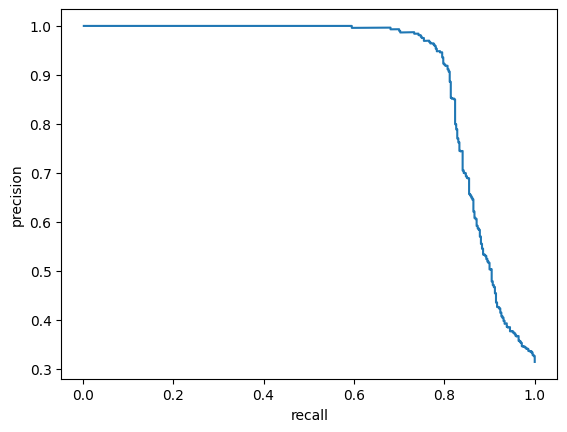

In [26]:
# plot the tradeoff
plt.plot(scores['recall'],scores['precision'])
plt.ylabel('precision')
plt.xlabel('recall')

In [28]:
# Find the threshold that guarantees a 0.8 recall score
scores[scores['recall'] >= 0.8].threshold.max()

np.float64(0.3055393000253697)

In [29]:
model = LogisticRegression()
model.fit(X, data['price_range_encoded'])

def custom_predict(X, custom_threshold):
    probs = model.predict_proba(X) # Get likelihood of each sample being classified as 0 or 1

    expensive_probs = probs[:, 1] # Only keep expensive likelihoods (1)

    return (expensive_probs > custom_threshold).astype(int) # Boolean outcome converted to 0 or 1

updated_preds = custom_predict(X=X, custom_threshold=0.305539) # Update predictions

print("Recall:", recall_score(data['price_range_encoded'], updated_preds))
print("Precision:", precision_score(data['price_range_encoded'], updated_preds))
print("F1 Score:", f1_score(data['price_range_encoded'], updated_preds))

Recall: 0.8071428571428572
Precision: 0.9287671232876712
F1 Score: 0.8636942675159236


## ROC-AUC

In [31]:
# Extract associated metrics and thresholds
fpr, tpr, thresholds = roc_curve(data['price_range_encoded'], data['proba_expensive'])

# Compute AUC score
auc_score = roc_auc_score(data['price_range_encoded'], data['proba_expensive'])
auc_score

0.9090439879655565